In [3]:
import os
import sys
sys.path.append('/Users/aghavamp/Desktop/Projects')
sys.path.append('/Users/aghavamp/Desktop/Projects/Functional_Fusion')
import getpass
import importlib

import scipy.io as sio
import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from pathlib import Path
import seaborn as sns
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel
import glob
import matplotlib.patches as patches

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'


## Get region data

In [9]:
sn = 8
glm = 3
region_labels = [1, 2, 3, 4, 5, 6, 7, 8]
region_names = ['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp']

#  Define atlas map
white = os.path.join(baseDir, surfacewbDir, f's{sn:02d}', f's{sn:02d}.L.white.32k.surf.gii') # Individual white surface
pial = os.path.join(baseDir, surfacewbDir, f's{sn:02d}', f's{sn:02d}.L.pial.32k.surf.gii') # Invividual pial surface
mask = os.path.join(baseDir, f'glm{glm}', f's{sn:02d}', 'mask.nii') # Mask in functional space for that subject

# File names for data extraction
nii_names = sorted(glob.glob(os.path.join(baseDir, f'glm{glm}', f's{sn:02d}', "beta_*.nii")))
nii_names = nii_names[0:480] # remove the run constant regressors
resMS_name = [os.path.join(baseDir, f'glm{glm}', f's{sn:02d}', 'ResMS.nii')]
spmT_names = glob.glob(os.path.join(baseDir, f'glm{glm}', f's{sn:02d}', "spmT*.nii"))

beta = []
resMS = []
beta_white = []
spmT = []
for i, r in enumerate(region_labels):
    print(f'Extracting region {region_names[i]} ({r})')
    atlas,_ = am.get_atlas('fs32k')
    atlas_left = atlas.get_hemisphere(0)
    subatlas = atlas_left.get_subatlas_image(os.path.join(atlasDir,'ROI.32k.L.label.gii'), value=r)
    amap = am.AtlasMapSurf(subatlas.vertex[0],white,pial,mask) # Atlas map
    # Compute the voxels in native space
    amap.build()

    # save the ROI mask in native space for checking purposes
    amap.save_as_image(os.path.join(baseDir, regDir, f's{sn:02d}', f'amap_ROI_{sn:02d}_glm{glm}_{region_names[i]}.nii'))
    
    # This extract all the relevant voxels in native space (use for RSA)
    beta.append(amap.extract_data_native(nii_names))
    resMS.append(amap.extract_data_native(resMS_name))
    beta_white.append(beta[i]/np.sqrt(resMS[i]))
    spmT.append(amap.extract_data_native(spmT_names))

regressor_info = pd.read_table(os.path.join(baseDir, f'glm{glm}', f's{sn:02d}', 'reginfo.tsv'))


Extracting region S1 (1)
Extracting region M1 (2)
Extracting region PMd (3)
Extracting region PMv (4)
Extracting region SMA (5)
Extracting region V1 (6)
Extracting region SPLa (7)
Extracting region SPLp (8)


## Reliability

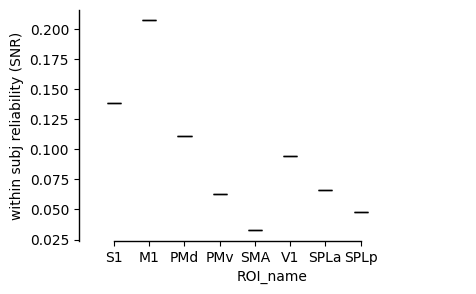

M1+S1 SNR: mean = 17.28100409821075


In [10]:
snr_dict = {
    'ROI': [],
    'ROI_name': [],
    'SNR': []
}

part_vec = regressor_info['run'].values.flatten()
conds = regressor_info['name'].values.flatten()
# conds_shortened = [s.split(":")[1].split(",")[0] + "_r" + s.split(":")[2] for s in conds]
# conds_chords_only = [s.split(":")[1].split(",")[0] for s in conds]
# conds = np.array(conds_chords_only)
# conds = np.array(conds_shortened)

for i, r in enumerate(region_labels):
    X = beta_white[i]   # region data: N by P matrix
    # remove nan columns:
    X = X[:, ~np.isnan(X).all(axis=0)]
    
    snr = rel.within_subj(X, conds, part_vec, separate='none',
                                            subtract_mean=True)
    
    # Make a n_partition X n_cond X n_voxels matrix:
    # Determine unique conditions and number of partitions
    # N = X.shape[0]
    # P = X.shape[1]
    # unique_conds = np.unique(conds)
    # n_cond = len(unique_conds)
    # n_partition = N // n_cond  # Assumes conditions are evenly distributed across partitions

    # # Create Y by grouping rows based on condition labels
    # Y = np.zeros((n_partition, n_cond, P))  # Initialize output
    # for j, cond in enumerate(unique_conds):  # Loop over conditions
    #     Y[:, j, :] = X[conds == cond]  # Select rows where condition matches

    # snr = ds.decompose_pattern_into_group_indiv_noise([Y], criterion='condition_wise') # DOES NOT WORK WITH ONE SUBEJCT
    
    # Append to data list
    for s in snr:
        snr_dict['ROI'].append(r)
        snr_dict['ROI_name'].append(region_names[i])
        snr_dict['SNR'].append(s)

# Convert to DataFrame
snr_df = pd.DataFrame(snr_dict)

# Define custom properties for the box plot
boxprops = dict(edgecolor='#000000', linewidth=1)
whiskerprops = dict(color='#000000', linewidth=1)
capprops = dict(visible=False)  # Remove the caps
medianprops = dict(color='#000000', linewidth=1)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.boxplot(data=snr_df, x='ROI_name', y='SNR', dodge=True, width=0.4, color='#ffffff', ax=ax,
            boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops)

ax.set_xlim([-1, 10])
# ax.set_ylim([0, 0.1])
ax.set_ylabel('within subj reliability (SNR)')

# Make it pretty:
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

ax.spines["left"].set_bounds(ax.get_ylim()[0], ax.get_ylim()[-1])
ax.spines["bottom"].set_bounds(ax.get_xticks()[0], ax.get_xticks()[-1])

plt.savefig(os.path.join('figures',f'bmw_snr_s{sn:02d}_glm{glm}.pdf'), format='pdf', bbox_inches='tight')

plt.show()

# print M1 and S1 SNR:
avg_snr = np.mean(snr_df[snr_df['ROI'].isin([1,2])]['SNR'].values)
print(f'M1+S1 SNR: mean = {avg_snr.mean()*100}')